In [44]:
import torch
from torch import nn
import train
import utils
from importlib import reload
reload(train)

train.set_namespace('05-resnet-03')

In [45]:
train_dl, test_dl, classes = utils.make_cifar_dataloaders_without_validation()

Files already downloaded and verified
Files already downloaded and verified


In [46]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [47]:
model = train.Model('resnet-18-01', resnet18(), 'CIFAR-100: Copied from pytorch-cifar100 reference repo')

Initial val_loss=4.6054, val_accuracy=0.0125
Saved model resnet-18-01 checkpoint 0001. epoch=0, step=0. val_loss=4.6054, val_accuracy=0.0125
Epoch 1/10: train_loss=3.7732, train_accuracy=0.1233, val_loss=3.4523, val_accuracy=0.1816
Saved model resnet-18-01 checkpoint 0001. epoch=1, step=782. train_loss=3.7732, train_accuracy=0.1233, val_loss=3.4523, val_accuracy=0.1816
Epoch 2/10: train_loss=2.9923, train_accuracy=0.2485, val_loss=3.0130, val_accuracy=0.2673
Saved model resnet-18-01 checkpoint 0001. epoch=2, step=1564. train_loss=2.9923, train_accuracy=0.2485, val_loss=3.0130, val_accuracy=0.2673
Epoch 3/10: train_loss=2.5135, train_accuracy=0.3443, val_loss=2.5029, val_accuracy=0.3621
Saved model resnet-18-01 checkpoint 0001. epoch=3, step=2346. train_loss=2.5135, train_accuracy=0.3443, val_loss=2.5029, val_accuracy=0.3621
Epoch 4/10: train_loss=2.2324, train_accuracy=0.4016, val_loss=2.3882, val_accuracy=0.3816
Saved model resnet-18-01 checkpoint 0001. epoch=4, step=3128. train_loss=

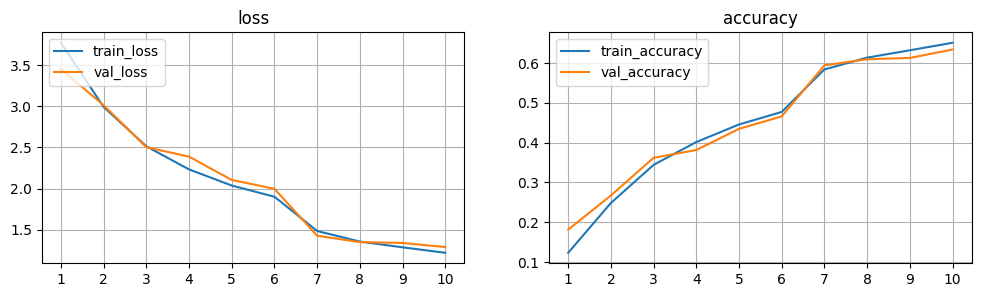

In [48]:
with model.checkpoint(1, 'Basic Adam') as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=5, gamma=0.2)
    )
    hist = cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics(hist)


Initial val_loss=1.3016, val_accuracy=0.6249
Saved model resnet-18-01 checkpoint 0002. epoch=10, step=7820. val_loss=1.3016, val_accuracy=0.6249
Epoch 1/10: train_loss=1.1585, train_accuracy=0.6639, val_loss=1.2770, val_accuracy=0.6352
Saved model resnet-18-01 checkpoint 0002. epoch=11, step=8602. train_loss=1.1585, train_accuracy=0.6639, val_loss=1.2770, val_accuracy=0.6352
Epoch 2/10: train_loss=0.9931, train_accuracy=0.7144, val_loss=1.1558, val_accuracy=0.6672
Saved model resnet-18-01 checkpoint 0002. epoch=12, step=9384. train_loss=0.9931, train_accuracy=0.7144, val_loss=1.1558, val_accuracy=0.6672
Epoch 3/10: train_loss=0.9480, train_accuracy=0.7269, val_loss=1.1348, val_accuracy=0.6707
Saved model resnet-18-01 checkpoint 0002. epoch=13, step=10166. train_loss=0.9480, train_accuracy=0.7269, val_loss=1.1348, val_accuracy=0.6707
Epoch 4/10: train_loss=0.9168, train_accuracy=0.7323, val_loss=1.1292, val_accuracy=0.6779
Saved model resnet-18-01 checkpoint 0002. epoch=14, step=10948. 

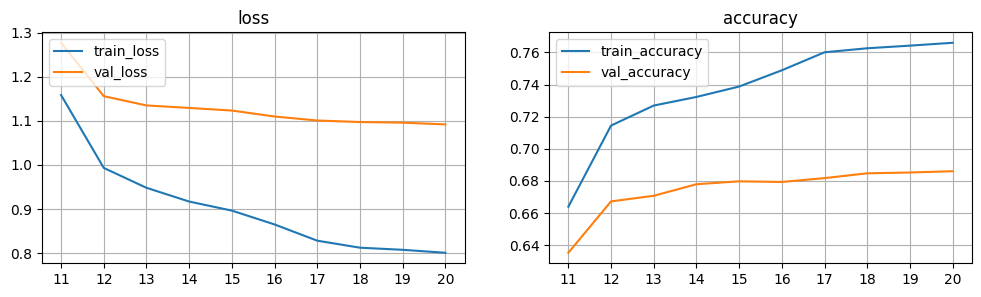

In [51]:
with model.checkpoint(2, 'Basic Adam: Continued') as cp:
    hist = cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics(hist)


Initial val_loss=1.0918, val_accuracy=0.6860
Saved model resnet-18-01 checkpoint 0003. epoch=20, step=15640. val_loss=1.0918, val_accuracy=0.6860


100%|██████████| 157/157 [00:03<00:00, 40.94it/s]


Epoch 1/10: train_loss=0.7938, train_accuracy=0.7689, val_loss=1.0921, val_accuracy=0.6859


100%|██████████| 157/157 [00:03<00:00, 41.11it/s]


Epoch 2/10: train_loss=0.7826, train_accuracy=0.7734, val_loss=1.0929, val_accuracy=0.6869
Saved model resnet-18-01 checkpoint 0003. epoch=22, step=17204. train_loss=0.7826, train_accuracy=0.7734, val_loss=1.0929, val_accuracy=0.6869


100%|██████████| 157/157 [00:03<00:00, 40.92it/s]


Epoch 3/10: train_loss=0.7828, train_accuracy=0.7724, val_loss=1.0924, val_accuracy=0.6858


100%|██████████| 157/157 [00:03<00:00, 41.03it/s]


Epoch 4/10: train_loss=0.7811, train_accuracy=0.7760, val_loss=1.0922, val_accuracy=0.6855


100%|██████████| 157/157 [00:16<00:00,  9.41it/s]


Epoch 5/10: train_loss=0.7772, train_accuracy=0.7758, val_loss=1.0882, val_accuracy=0.6866


100%|██████████| 157/157 [00:02<00:00, 60.97it/s]


Epoch 6/10: train_loss=0.7790, train_accuracy=0.7758, val_loss=1.0883, val_accuracy=0.6856


100%|██████████| 157/157 [00:02<00:00, 61.23it/s]


Epoch 7/10: train_loss=0.7717, train_accuracy=0.7756, val_loss=1.0920, val_accuracy=0.6864


100%|██████████| 157/157 [00:02<00:00, 60.24it/s]


Epoch 8/10: train_loss=0.7776, train_accuracy=0.7748, val_loss=1.0857, val_accuracy=0.6869


100%|██████████| 157/157 [00:02<00:00, 60.64it/s]


Epoch 9/10: train_loss=0.7708, train_accuracy=0.7791, val_loss=1.0896, val_accuracy=0.6873
Saved model resnet-18-01 checkpoint 0003. epoch=29, step=22678. train_loss=0.7708, train_accuracy=0.7791, val_loss=1.0896, val_accuracy=0.6873


100%|██████████| 157/157 [00:02<00:00, 61.48it/s]


Epoch 10/10: train_loss=0.7703, train_accuracy=0.7757, val_loss=1.0884, val_accuracy=0.6867
Created backup for model resnet-18-01 checkpoint 0003.
Saved model resnet-18-01 checkpoint 0003. epoch=30, step=23460. train_loss=0.7703, train_accuracy=0.7757, val_loss=1.0884, val_accuracy=0.6867


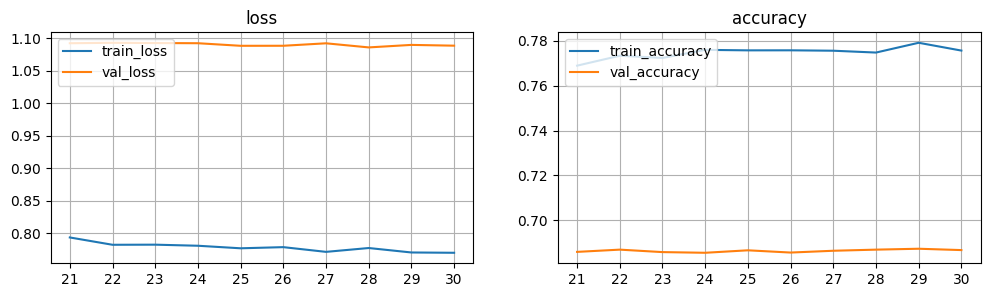

In [52]:
with model.checkpoint(3, 'Basic Adam: Continued') as cp:
    hist = cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics(hist)


Initial val_loss=1.0884, val_accuracy=0.6867
Saved model resnet-18-01 checkpoint 0004. epoch=30, step=23460. val_loss=1.0884, val_accuracy=0.6867


100%|██████████| 157/157 [00:02<00:00, 60.81it/s]


Epoch 1/10: train_loss=0.7763, train_accuracy=0.7753, val_loss=1.0902, val_accuracy=0.6873
Saved model resnet-18-01 checkpoint 0004. epoch=31, step=24242. train_loss=0.7763, train_accuracy=0.7753, val_loss=1.0902, val_accuracy=0.6873


100%|██████████| 157/157 [00:02<00:00, 60.68it/s]


Epoch 2/10: train_loss=0.7710, train_accuracy=0.7769, val_loss=1.0945, val_accuracy=0.6855


100%|██████████| 157/157 [00:02<00:00, 61.29it/s]


Epoch 3/10: train_loss=0.7754, train_accuracy=0.7744, val_loss=1.0891, val_accuracy=0.6875
Saved model resnet-18-01 checkpoint 0004. epoch=33, step=25806. train_loss=0.7754, train_accuracy=0.7744, val_loss=1.0891, val_accuracy=0.6875


100%|██████████| 157/157 [00:02<00:00, 61.04it/s]


Epoch 4/10: train_loss=0.7720, train_accuracy=0.7760, val_loss=1.0929, val_accuracy=0.6873


100%|██████████| 157/157 [00:02<00:00, 61.13it/s]


Epoch 5/10: train_loss=0.7748, train_accuracy=0.7761, val_loss=1.0890, val_accuracy=0.6885
Saved model resnet-18-01 checkpoint 0004. epoch=35, step=27370. train_loss=0.7748, train_accuracy=0.7761, val_loss=1.0890, val_accuracy=0.6885


100%|██████████| 157/157 [00:02<00:00, 61.30it/s]


Epoch 6/10: train_loss=0.7737, train_accuracy=0.7772, val_loss=1.0972, val_accuracy=0.6838


100%|██████████| 157/157 [00:02<00:00, 61.12it/s]


Epoch 7/10: train_loss=0.7738, train_accuracy=0.7749, val_loss=1.0888, val_accuracy=0.6855


100%|██████████| 157/157 [00:02<00:00, 61.20it/s]


Epoch 8/10: train_loss=0.7728, train_accuracy=0.7777, val_loss=1.0906, val_accuracy=0.6866


100%|██████████| 157/157 [00:02<00:00, 61.98it/s]


Epoch 9/10: train_loss=0.7716, train_accuracy=0.7765, val_loss=1.0929, val_accuracy=0.6861


100%|██████████| 157/157 [00:02<00:00, 61.34it/s]


Epoch 10/10: train_loss=0.7714, train_accuracy=0.7763, val_loss=1.0895, val_accuracy=0.6871
Created backup for model resnet-18-01 checkpoint 0004.
Saved model resnet-18-01 checkpoint 0004. epoch=40, step=31280. train_loss=0.7714, train_accuracy=0.7763, val_loss=1.0895, val_accuracy=0.6871


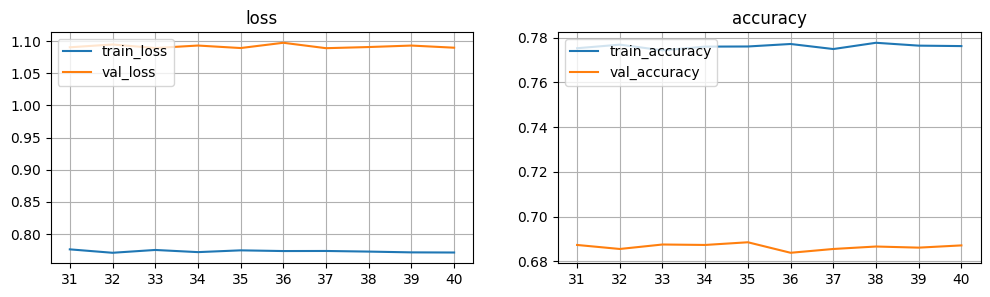

In [53]:
with model.checkpoint(4, 'Basic Adam: Continued') as cp:
    hist = cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics(hist)


In [55]:
model.evaluate(test_dl, metrics=[train.metric_accuracy])

{'loss': 1.089547989463806, 'accuracy': 0.6871}

In [56]:
model.load_checkpoint(4, from_backup=True)

In [57]:
model.evaluate(test_dl, metrics=[train.metric_accuracy])

{'loss': 1.0890234186172485, 'accuracy': 0.6885}